In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title cd
%pwd
%cd /content/drive/MyDrive/afeka/Project/code/PTEEnet/PTEEnet

/content/drive/MyDrive/afeka/Project/code/PTEEnet/PTEEnet


In [3]:
#@title install packages
%pip install chainer
%pip install -Uqq ipdb

In [4]:
#@title read gpu details
import chainer
#chainer.print_runtime_info()

print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


GPU availability: True
cuDNN availablility: True
Sat Jan 22 19:44:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                       

In [5]:
#@title imports
"""
high level support for doing this and that.
"""
from __future__ import print_function
import time
import csv
import numpy as np
import torch
import torch.nn.functional as F
from scipy import stats
from init import initializer
from eenet import EENet
from custom_eenet import CustomEENet
from gatednet import GatedNet
import matplotlib.pylab as plt
import loss_functions
import utils
import config
import gc
import sys
import math
import os
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
import ipdb

import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import joblib as jobl
from collections import Counter
from matplotlib import pyplot
from numpy import where
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor

%matplotlib inline


In [6]:
#@title plot_ee_histogram
def plot_ee_histogram(args, val_confs, type_loader, dir):
    %matplotlib inline
    x_pos = np.arange(args.num_ee+1)
    #print(x_pos)
    print(val_confs)
    bar = plt.bar(x_pos, val_confs, align='center')
    plt.xlabel('Exit number')
    plt.ylabel('# of Samples in Exit')
    plt.title(args.dataset + ' ' +  type_loader + ' samples distribution in exits using ' + args.model + 
              ' model\n')
    plt.ylim(0, max(val_confs))
    plt.savefig(dir + '/ee_hist_' + type_loader + '.' + str(args.loss_threshold) + '.png')
    plt.show()
    

In [7]:
#@title generate_ee_exit_prediction_ground_truths
def generate_ee_exit_prediction_ground_truths(args, model, train_loader, test_loader):
    
    model.eval()
    #model.set_full_flow(True)
    
    loader_types = ['train', 'test']
    loaders = [train_loader, test_loader]
    for loader_id, loader_type in enumerate(loader_types):
        first = True
        loader = loaders[loader_id]
        exit_idx_predictions = []
        datas = []
        targets = []
        #loss_main = []
        main_ee_losses = []
        exit_points = [0]*(args.num_ee+1)
        
        print('processing loader type: ', loader_type)
        print('batch size: {:d}'.format(args.batch_size))
        print('---------------------------------------------------')
        
        with torch.no_grad():
            for data, target_org in loader:
                
                batch_size = target_org.shape[0]        
                data, target_org = data.to(args.device), target_org.to(args.device)
                preds, _ = model(data)
                
                if args.use_main_targets:
                    _, target = torch.max(preds[args.num_ee], 1)
                else:
                    target = target_org

                target = target.to(args.device)
                
                pred_losses = torch.empty((args.num_ee + 1, batch_size), dtype=torch.float)
                pred = torch.zeros((batch_size, preds[0].shape[1]), dtype=torch.float, device = args.device)
                best_exit_batch = np.full(batch_size, args.num_ee, dtype=int)
                
                for i in range(args.num_ee+1):
                    cost = model.complexity[i][0]/model.complexity[-1][0]
                    pred_losses[i] = F.nll_loss(preds[i].log(), target, reduction='none')# +\
                    #        args.lambda_coef * cost
                main_ee_loss = F.nll_loss(preds[args.num_ee].log(), target_org)
                main_ee_losses.append(float(main_ee_loss))
                
                for j in range(batch_size):
                    best_exit = args.num_ee
                    for i in range(args.num_ee):    
                        if pred_losses[i][j] < args.loss_threshold:
                            best_exit = i
                            break
                    
                    exit_points[best_exit] += 1
                    best_exit_batch[j] = best_exit
                    
                #ipdb.set_trace(context=6)
                exit_idx_predictions = np.append(exit_idx_predictions, best_exit_batch)
                
                if first:
                    first = False
                    datas = data.cpu().detach().numpy()
                else:
                    datas = np.append(datas, data.cpu().detach().numpy(), axis=0)
                
                targets = np.append(targets, target.cpu().detach().numpy())
                #loss_main.append(float(F.nll_loss(preds[args.num_ee].log(), target)))
                
        print('exit_idx_predictions length {:8d}'.format(len(exit_idx_predictions)))
        print('loss_main mean: {:.2f}'.format(round(np.mean(main_ee_losses), 4)))
        
        ground_truth_noisy_dir = args.ground_truths_dir + '/' + str(args.loss_threshold)# + '/' + 'snr_' + str(noise_levels[m])
        if not os.path.exists(ground_truth_noisy_dir):
            os.makedirs(ground_truth_noisy_dir)

        torch.save(exit_idx_predictions, ground_truth_noisy_dir
                + '/exit_idx_predictions_' + loader_type + '.' + str(args.loss_threshold) + '.pt')
        torch.save(datas, ground_truth_noisy_dir + '/datas_' + loader_type + '.' + str(args.loss_threshold) + '.pt')
        torch.save(targets, ground_truth_noisy_dir + '/targets_' + loader_type + '.' + str(args.loss_threshold) + '.pt')
        plot_ee_histogram(args, exit_points, loader_type, ground_truth_noisy_dir)
        

In [8]:
#@title load data
from torch.utils.data import Dataset, TensorDataset, DataLoader

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        #ipdb.set_trace(context=6)
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]
        
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
        
#def load_data(args):
#    return utils.load_custom_dataset(args)

def load_data(args):
    serialized_data_dir = 'serialized_data'
    
    data_file_train = serialized_data_dir + '/datas_train' + '.pt'
    data_train = torch.load(data_file_train)
    print('loaded data train at: ', data_file_train)
    
    data_file_test = serialized_data_dir + '/datas_test' + '.pt'
    data_test = torch.load(data_file_test)
    print('loaded data test at: ', data_file_test)
    
    gt_file_train = serialized_data_dir + '/targets_train' + '.pt'
    target_train = torch.load(gt_file_train)
    print('loaded exits ground truths train at: ', gt_file_train)
    
    gt_file_test = serialized_data_dir + '/targets_test' + '.pt'
    target_test = torch.load(gt_file_test)
    print('loaded exits ground truths test at: ', gt_file_test)

    """
    data_train, data_test, target_train, target_test = train_test_split(data_train,\
                                                                        target_train, test_size=0.33, random_state=42)
    """
    data_train, target_train = torch.from_numpy(data_train), torch.from_numpy(target_train)    
    data_test, target_test = torch.from_numpy(data_test), torch.from_numpy(target_test)
    
    train_set = CustomTensorDataset(tensors=(data_train, target_train))    
    validation_set = CustomTensorDataset(tensors=(data_test, target_test))
    loader_train = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=args.shuffle_train)
    loader_val = torch.utils.data.DataLoader(validation_set, batch_size=args.test_batch, shuffle=args.shuffle_test)

    return loader_train, loader_val

In [9]:
#@title main

"""Main function of the program.

The function loads the dataset and calls training and validation functions.
"""
%load_ext autoreload
%autoreload 2

import importlib
importlib.reload(config)
importlib.reload(loss_functions)
importlib.reload(utils)
from enum import Enum

class Mode(Enum):
    train_main = 0
    train_ee = 1
    generate_exits_gt = 2 
    train_gating = 3
    generate_relative_loss = 4 
    plot_relative_loss = 5
    calc_relative_time = 6

def main(mode: Mode):
    print(mode.value)
    args = config.args_global
    args += config.argu[mode.value]
    
    %pwd
    model, optimizer, lr_scheduler, args = initializer(args)
    print(args)
    
    if mode == Mode.generate_exits_gt:
        #train_loader, test_loader, exit_tags, trainset, testset = load_data(args)       
        train_loader, test_loader = load_data(args)       
        for thresh in range(2, 18, 3):
            args.loss_threshold = thresh/10
            print('\n\n\nGenerating ground truth for ee loss, threshold = {:.2f}'.format(args.loss_threshold))
            generate_ee_exit_prediction_ground_truths(args, model, train_loader, test_loader)
    
    print('Finished')

2
use cuda:  True  device:  cuda
empty model loaded at:  main_models/models/cifar10/eenet110/UT/clean/after_ee_training/model.pt
ee-block-0: flops=19.78 MMac, params=19.34 k, cost-rate=0.08
ee-block-1: flops=34.23 MMac, params=33.35 k, cost-rate=0.13
ee-block-2: flops=43.86 MMac, params=42.7 k, cost-rate=0.17
ee-block-3: flops=53.49 MMac, params=52.04 k, cost-rate=0.21
ee-block-4: flops=63.13 MMac, params=61.39 k, cost-rate=0.25
ee-block-5: flops=72.76 MMac, params=70.73 k, cost-rate=0.28
ee-block-6: flops=82.4 MMac, params=80.08 k, cost-rate=0.32
ee-block-7: flops=92.03 MMac, params=89.42 k, cost-rate=0.36
ee-block-8: flops=100.48 MMac, params=136.57 k, cost-rate=0.39
ee-block-9: flops=110.01 MMac, params=173.69 k, cost-rate=0.43
exit-block: flops=256.32 MMac, params=1.73 M, cost-rate=1.00
Namespace(adaptive_lr=False, add_noise=False, batch_size=128, clear_dirs=False, dataset='cifar10', device=device(type='cuda'), distribution='fine', ee_costs=None, epochs=150, exit_type='conv2', filt

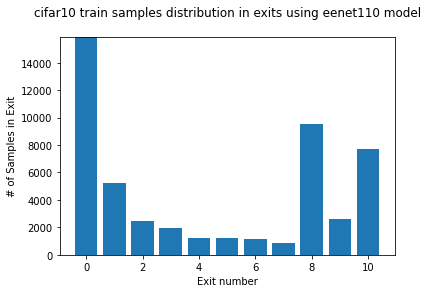

processing loader type:  test
batch size: 128
---------------------------------------------------
exit_idx_predictions length    10000
loss_main mean: 0.12
[3081, 1017, 540, 393, 205, 262, 213, 192, 1587, 604, 1906]


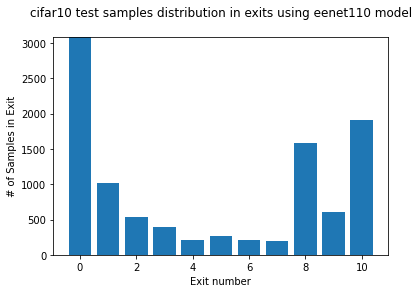




Generating ground truth for ee loss, threshold = 0.50
processing loader type:  train
batch size: 128
---------------------------------------------------
exit_idx_predictions length    50000
loss_main mean: 0.09
[25254, 5614, 2770, 1732, 1084, 1084, 1018, 599, 5695, 1521, 3629]


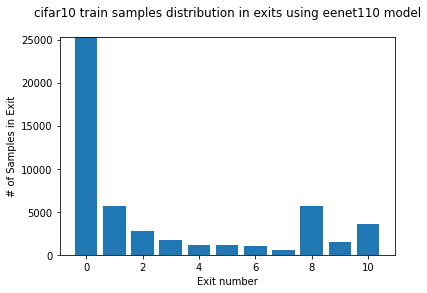

processing loader type:  test
batch size: 128
---------------------------------------------------
exit_idx_predictions length    10000
loss_main mean: 0.12
[4931, 1051, 586, 356, 235, 207, 164, 119, 883, 373, 1095]


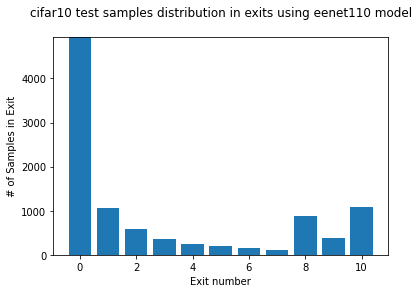




Generating ground truth for ee loss, threshold = 0.80
processing loader type:  train
batch size: 128
---------------------------------------------------
exit_idx_predictions length    50000
loss_main mean: 0.09
[31196, 5101, 2634, 1450, 893, 833, 851, 400, 3658, 877, 2107]


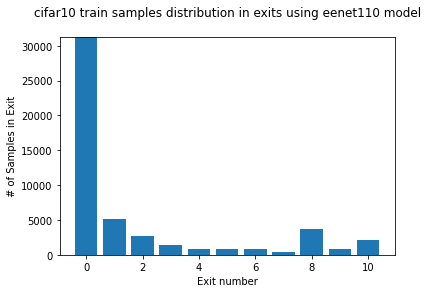

processing loader type:  test
batch size: 128
---------------------------------------------------
exit_idx_predictions length    10000
loss_main mean: 0.12
[6027, 1022, 520, 323, 172, 170, 168, 89, 580, 234, 695]


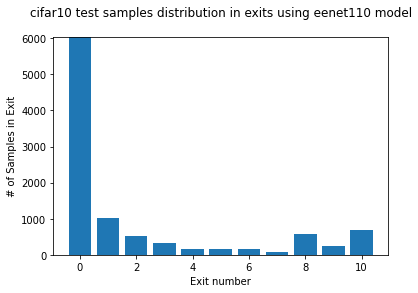




Generating ground truth for ee loss, threshold = 1.10
processing loader type:  train
batch size: 128
---------------------------------------------------
exit_idx_predictions length    50000
loss_main mean: 0.09


KeyboardInterrupt: ignored

In [10]:
mode = Mode.generate_exits_gt
main(mode)